In [1]:
#IMPORT USED PACKAGES AND SET SEED
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import *
import pickle
import random
from datetime import datetime
import pandas as pd
import csv
import pbs
import os
import sys
import itertools
import json
from multiprocessing import Pool
from spellchecker import SpellChecker
from IPython.display import display
random.seed(123)

In [5]:
time = datetime.strftime(datetime.now(), "%Y_%m_%d_%H_%M_%S")

# Preprocessing

#### Remove automatic tweets about pictures that occur only in the negative dataset

In [ ]:
def is_picture_tweet(str):
    

def drop_frame():
    with open("Datasets/"+input_filename, encoding="utf-8") as f :
        tweets = f.read().splitlines()
        df_tweets = pd.DataFrame(tweets,columns=['Tweets'])
        df_tweets["Tweets"].apply(lambda str : )
    with open('Processed_data/no_dupl_' + input_filename, "w+", encoding = "UTF-8") as f:
        for tweet in df_tweets["Tweets"]:
            f.write("%s\n" % tweet)

#### Remove duplicated tweets

In [6]:
def drop_duplicate(input_filename):
    with open("Datasets/"+input_filename, encoding="utf-8") as f :
        tweets = f.read().splitlines()
        df_tweets = pd.DataFrame(tweets,columns=['Tweets'])
        df_tweets.drop_duplicates(inplace=True)
    with open('Processed_data/no_dupl_' + input_filename, "w+", encoding = "UTF-8") as f:
        for tweet in df_tweets["Tweets"]:
            f.write("%s\n" % tweet)

In [7]:
for file in ['train_pos.txt','train_neg.txt','train_neg_full.txt','train_pos_full.txt']:
    drop_duplicate(file)

In [8]:
# drop duplicates test
with open("Datasets/test_data.txt", encoding="utf-8") as f :
    test = f.read().splitlines()
    tweets = []
    ids = []
    for line in test:
        id, tweet = line.split(',',1)
        tweets.append(tweet)
        ids.append(id)
    df_test = pd.DataFrame(tweets,ids,columns=['Tweets'])
    df_test.drop_duplicates(inplace=True)
    
with open('Processed_data/no_dupl_test_data.txt', "w+", encoding = "UTF-8") as f:
    for tweet in df_test["Tweets"]:
        f.write("%s\n" % tweet)

#### Concatenate all text files (pos, neg and test) to create a dataset used as reference for twitter language

In [ ]:
with open("Processed_data/twitter_language.txt", "w+", encoding = "utf-8") as f:
    for path in ['Processed_data/no_dupl_train_pos.txt','Processed_data/no_dupl_train_neg.txt', 'Processed_data/no_dupl_test_data.txt']:
        with open(path,encoding="utf-8") as file:
            f.write(file.read())

In [ ]:
with open("Processed_data/twitter_language_full.txt", "w+", encoding = "utf-8") as f:
    for path in ['Processed_data/no_dupl_train_pos_full.txt','Processed_data/no_dupl_train_neg_full.txt', 'Processed_data/no_dupl_test_data.txt']:
        with open(path,encoding="utf-8") as file:
            f.write(file.read())

###  Spell correction

In [ ]:
## Create a frequency dictionnary of words occuring at least *threshold* times in the dataset, 
## that will be used as a reference for spell checking

output_filename = 'Processed_data/vocab_freq.txt'
vocab_successful = os.system("build_vocab.sh Processed_data/twitter_language.txt " + output_filename)

if (vocab_successful != 0):
    sys.exit("Building vocabulary failed.")

In [ ]:
## Create a frequency dictionnary of words occuring at least *threshold* times in the dataset, 
## that will be used as a reference for spell checking

output_filename = 'Processed_data/vocab_freq_full.txt'
vocab_successful = os.system("build_vocab.sh Processed_data/twitter_language_full.txt " + output_filename)

if (vocab_successful != 0):
    sys.exit("Building vocabulary failed.")

In [3]:
def build_dictionnary(input_vocab, threshold):
    full_vocab = pd.read_csv(input_vocab+".txt", sep = "\s+", header=None, engine='python')
    cut_vocab = full_vocab[full_vocab[0] >= threshold]
    cut_vocab.columns = ["number occ","word"]
    cut_vocab.set_index("word",inplace=True)
    with open(input_vocab + "_" + str(threshold) + '.json', 'w') as f:
        json.dump(cut_vocab["number occ"].to_dict(), f)

#build_dictionnary("Processed_data/vocab_freq", threshold=5) #TODO try other threshold
#build_dictionnary("Processed_data/vocab_freq_full", threshold=5) #TODO try other threshold

In [4]:
## Spell correction functions
def correct(tweet, dict_corr):
    list_words = tweet.split()
    for i, word in enumerate(list_words):
        if word in dict_corr :
            list_words[i] = dict_corr[word]
    corr_tweet = ' '.join(list_words)
    return (corr_tweet) 

def spell_correction(data, reference_dictionnary_filename):
    spell = SpellChecker(distance=1) # TODO if possible, try distance=2
    spell.word_frequency.load_dictionary(reference_dictionnary_filename) 
    dict_corr = {}
    for tweet in data["Tweets"]:
        list_words = tweet.split()
        for i, word in enumerate(list_words):
            if word not in dict_corr :
                if word in spell.unknown([word]):
                    dict_corr[word] = spell.correction(word)
    data["Tweets"] = data["Tweets"].apply(lambda x : correct(x, dict_corr))
    return data, dict_corr

In [ ]:
#Define the used datasets here
positive_dataset = 'Processed_data/no_dupl_train_pos_full.txt' #'Processed_data/no_dupl_train_pos_full.txt'
negative_dataset = 'Processed_data/no_dupl_train_neg_full.txt' #'Processed_data/no_dupl_train_neg_full.txt'

def load_in_pd(data_path):
    with open(data_path, encoding="utf-8") as f :
        x = f.read().splitlines()
        x = pd.DataFrame(x,columns=['Tweets'])
    return (x)

positive_pd = load_in_pd(positive_dataset)
negative_pd = load_in_pd(negative_dataset)

In [ ]:
%%time
### APPLYING spell correction to pos and neg

positive_preprocessed, dict_corr1 = spell_correction(positive_pd,'Processed_data/vocab_freq_full.json') #'Processed_data/vocab_freq_full.json') 
with open('Processed_data/' + 'positive_spell_full.txt', "w+", encoding = "UTF-8") as f: #positive_spell_full.txt', "w+", encoding = "UTF-8") as f:
    for tweet in positive_preprocessed["Tweets"]:
        f.write("%s\n" % tweet)
del positive_preprocessed
print("done positive")

negative_preprocessed, dict_corr2 = spell_correction(negative_pd,'Processed_data/vocab_freq_full.json') #'Processed_data/vocab_freq_full.json') 
with open('Processed_data/' + 'negative_spell_full.txt', "w+", encoding = "UTF-8") as f: #negative_spell_full.txt', "w+", encoding = "UTF-8") as f:
    for tweet in negative_preprocessed["Tweets"]:
        f.write("%s\n" % tweet)
del negative_preprocessed

In [ ]:
### APPLYING spell correction to test

test_dataset = "Datasets/test_data.txt"

def load_in_pd_test(data_path):
    with open(data_path, encoding="utf-8") as f :
        test = f.read().splitlines()
        tweets = []
        ids = []
        for line in test:
            id, tweet = line.split(',',1)
            tweets.append(tweet)
            ids.append(id)
        test = pd.DataFrame(tweets,ids,columns=['Tweets'])
    return test

test_pd = load_in_pd_test(test_dataset)
test_spell, dict_corr_test = spell_correction(test_pd,'Processed_data/vocab_freq_full.json') #'Processed_data/vocab_freq_full.json')  

with open("Processed_data/test_spell.txt", "w+", encoding="utf-8") as f:
    for index, row in test_spell.iterrows():
        f.write(index + "," + row["Tweets"] + "\n")

one done
one done
one done
one done
Wall time: 47min 57s


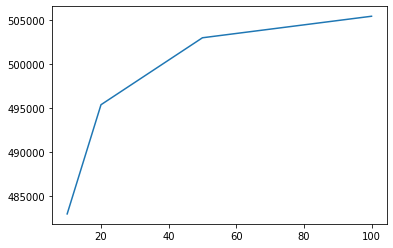

In [6]:
%%time
thresholds = [10,20,50,100]
nbr_corrected = []
for threshold in thresholds:
    build_dictionnary("Processed_data/vocab_freq_full", threshold=threshold)
    with open("Processed_data/twitter_language_full.txt", encoding="utf-8") as f :
        x = f.read().splitlines()
        x = pd.DataFrame(x,columns=['Tweets'])
    output, dict_corr = spell_correction(x,"Processed_data/vocab_freq_full_" + str(threshold) + '.json')
    corrected = {k:v for (k,v) in dict_corr.items() if v==v}
    nbr_corrected.append(len(corrected))
    print("one done")
plt.plot(thresholds,nbr_corrected)

In [ ]:
%%time
thresholds = [10,20,50,100]
dictionaries = []
nbr_corrected = []
ratio_corrected = []
for threshold in thresholds:
    build_dictionnary("Processed_data/vocab_freq_full", threshold=threshold)
    with open("Processed_data/twitter_language_full.txt", encoding="utf-8") as f :
        x = f.read().splitlines()
        x = pd.DataFrame(x,columns=['Tweets'])
    output, dict_corr = spell_correction(x,"Processed_data/vocab_freq_full_" + str(threshold) + '.json')
    dictionaries.append(dict_corr)
    corrected = {k:v for (k,v) in dict_corr.items() if v==v}
    nbr_corrected.append(len(corrected))
    ratio_corrected.append(len(corrected)/len(dict_corr))
    print("one done")

In [ ]:
plt.plot(thresholds,nbr_corrected)
plt.plot(thresholds,ratio_corrected)

.

.

.

.

.

In [ ]:
# gather input for word embeddings
with open("Processed_data/input_WE_full.txt", "w+", encoding = "utf-8") as f:
    with open("Processed_data/test_spell.txt",encoding="utf-8") as test:
        test = test.readlines()
        for line in test:
            id, tweet = line.split(',',1)
            f.write("%s" % tweet)
    
    for path in ['Processed_data/positive_spell_full.txt','Processed_data/negative_spell_full.txt']:
        with open(path,encoding="utf-8") as file:
            f.write(file.read())

In [ ]:
output_filename = 'Processed_data/vocab_freq_after_spell_full.txt' #'Processed_data/vocab_freq_after_spell_full.txt'
vocab_successful = os.system("build_vocab.sh Processed_data/input_WE_full.txt " + output_filename)

if (vocab_successful != 0):
    sys.exit("Building vocabulary failed.")


#### Find good minimal threshold on the number of occurrences

In [ ]:
full_vocab_spell = pd.read_csv('Processed_data/vocab_freq_after_spell_full.txt', sep = "\s+", header=None, engine='python')
full_vocab_spell.columns = ["number occ","word"]
full_vocab_spell.set_index("word",inplace=True)

In [ ]:
plt.subplots(figsize=(15,7))
plt.yscale("log")
plt.hist(full_vocab_spell["number occ"],bins=200)
plt.xlabel("Number of occurence")
plt.ylabel("Number of word")
plt.title("Histogram of the number of occurences of all different words in the whole dataset")
plt.fig_save("Plot/threshold_build_vocab_fig1.png")
plt.show()

NameError: name 'full_vocab_spell' is not defined

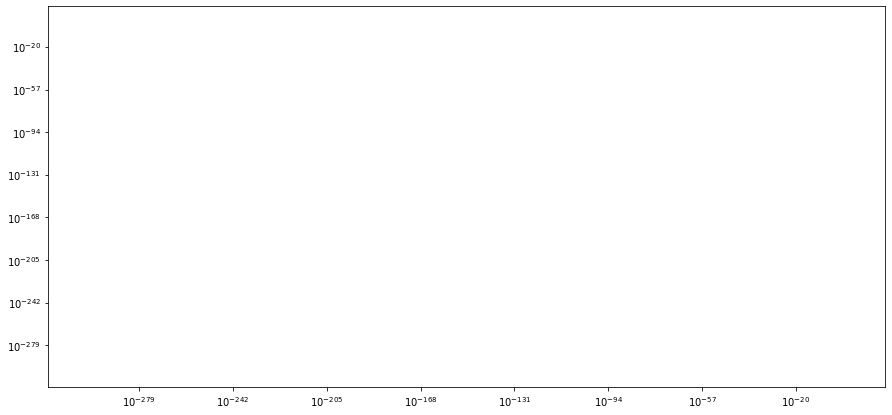

In [7]:
plt.subplots(figsize=(15,7))
plt.yscale("log")
plt.xscale("log")
plt.hist(full_vocab_spell["number occ"],bins=2**(np.arange(0,24)))
plt.xlabel("Number of occurence")
plt.ylabel("Number of word")
plt.title("Histogram of the number of occurences of all different words in the whole dataset")
plt.fig_save("Plot/threshold_build_vocab_fig2.png")
plt.show()

It's a power-law distribution !

In [ ]:
plt.subplots(figsize=(15,12))
x = range(1,100)
y1 = []
y2 = []
for threshold in x :
    y1.append(sum(full_vocab_spell["number occ"]>threshold))
    y2.append(sum(full_vocab_spell[full_vocab_spell["number occ"]>threshold]["number occ"]))
plt.subplot(211)
plt.xlabel("Minimal threshold of occurences")
plt.ylabel("Number of different word")
plt.ylim(0,max(y1)*1.1)
plt.plot(x,y1)
plt.subplot(212)
plt.xlabel("Minimal threshold of occurences")
plt.ylabel("Total number of words")
plt.ylim(0,max(y2)*1.1)
plt.plot(x,y2)
plt.fig_save("Plot/threshold_build_vocab_fig3.png")
plt.show()

In [ ]:
plt.yscale("log")
plt.hist(full_vocab_spell["number occ"],bins=50)
plt.show()

In [ ]:
# We choose threshold = 20

.

.

.

.

In [ ]:
full_vocab_spell[full_vocab_spell["number occ"]>20000].sort_values(by="number occ").to_csv("Stops" + time + ".csv", header= True, index_label = "Id")

In [ ]:
##APPLY build_vocab.sh AND CUT THE VOCABULARY USING THE CHOSEN THRESHOLD

#Choose the desired cutting parameter here (Tokens with >= cut_threshold occurrences are kept)
cut_threshold = 5

output_filename = 'Processed_data/vocab_full' + time + '.txt'
vocab_successful = os.system("sh build_vocab.sh Processed_data/input_WE_full.txt " + output_filename)

if (vocab_successful != 0):
    sys.exit("Building vocabulary failed.")
    
def cut_and_save_vocab(file_in, file_out):
    full_vocab = pd.read_csv(file_in, sep = "\s+", header=None, engine = 'python')
    cutted_vocab = full_vocab[full_vocab[0] >= cut_threshold][2]
    with open(file_out, 'w+') as f:
        f.write(cutted_vocab.to_string(header = False, index = False))
    
cut_and_save_vocab('Processed_data/vocab_full' + time + '.txt', 'Processed_data/vocab_cut_full' + time + '.txt')
    

In [ ]:
##DUMP THE BUILT VOCABULARY TO A PICKLE FILE
vocab = dict()
with open('Processed_data/vocab_cut_full' + time + '.txt') as f:
    for idx, line in enumerate(f):
        vocab[line.strip()] = idx

with open('Processed_data/vocab_full' + time + '.pkl', 'wb') as f:
    pickle.dump(vocab, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
%%time
##CREATE A CO-OCCURRENCE MATRIX with context defined with threshold distance
def context(lst,index,threshold):
    return(lst[index+1 : min(index+threshold, len(lst)-1)])

def create_cooc_dist(vocab_file, negative_file, positive_file, output_file, threshold):
    with open(vocab_file, 'rb') as f:
        vocab = pickle.load(f)
    vocab_size = len(vocab)
    data, row, col = [], [], []
    counter = 1
    for fn in [negative_file, positive_file]:
        with open(fn,encoding="utf8") as f:
            for line in f:
                tokens = [vocab.get(t, -1) for t in line.strip().split()]
                #tokens = [t for t in tokens if t >= 0]
                for i, t1 in enumerate(tokens):
                    if t1 >= 0:
                        for t2 in context(tokens,i,threshold):
                            if t2 >= 0:
                                if t1==t2 :
                                    data.append(1/2)
                                else :
                                    data.append(1)
                                row.append(min(t1,t2))
                                col.append(max(t1,t2))

                if counter % 100000 == 0:
                    print(counter)
                counter += 1

                if counter % 3000000 == 0:
                    print(len(data))
                    cooc = coo_matrix((data, (row, col)))
                    print("summing duplicates (this can take a while)")
                    cooc.sum_duplicates()
                    data=list(cooc.data)
                    row=list(cooc.row)
                    col=list(cooc.col)
                    print(len(data))

    print(len(data))
    final_row = row+col
    final_col = col+row
    data = data+data
    cooc = coo_matrix((data, (final_row, final_col)))
    print("Summing duplicates")
    cooc.sum_duplicates()
    
    with open(output_file, 'wb') as f:
        pickle.dump(cooc, f, pickle.HIGHEST_PROTOCOL)
        
#Used datasets should be defined on the second code block
create_cooc_dist('Processed_data/vocab_full' + time + '.pkl', 'Processed_data/negative_spell_full.txt', 'Processed_data/positive_spell_full.txt',
            'Processed_data/cooc_dist_pickle_full' + time + '.pkl', 3)

In [ ]:
#Do not create word embeddings for these stop words
def drop_stop_rows(cooc_path, stop_path, vocab_path, output_path):
    with open(cooc_path, 'rb') as f:
        cooc = pickle.load(f)
    with open(stop_path, encoding = "utf-8") as stoplist:
        words = stoplist.read().splitlines()
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
    stop_indexes = [vocab.get(t, -1) for t in words]
    keeps = np.logical_not(np.isin(cooc.row, stop_indexes))
    print(np.mean(keeps))
    new_cols = cooc.col[keeps]
    new_rows = cooc.row[keeps]
    new_data = cooc.data[keeps]
    new_cooc = coo_matrix((new_data, (new_rows, new_cols)))
    with open(output_path, 'wb') as f:
        pickle.dump(new_cooc, f, pickle.HIGHEST_PROTOCOL)
        
drop_stop_rows('Processed_data/cooc_dist_pickle_full' + time + '.pkl', "Stoplist.txt", 
              'Processed_data/vocab_full' + time + '.pkl', 'Processed_data/cooc_dist_pickle_cutted' + time + ''.pkl')      

In [ ]:
## CREATE WORD EMBEDDINGS
random.seed(123)
def glove(cooc_pickle, output_file):
    print("loading cooccurrence matrix")
    with open(cooc_pickle, 'rb') as f:
        cooc = pickle.load(f)
    print("{} nonzero entries".format(cooc.nnz))

    nmax = 100
    print("using nmax =", nmax, ", cooc.max() =", cooc.max())

    print("initializing embeddings")
    embedding_dim = 20
    xs = np.random.normal(size=(cooc.shape[0], embedding_dim))
    ys = np.random.normal(size=(cooc.shape[1], embedding_dim))

    eta = 0.001
    alpha = 3 / 4

    epochs = 10

    for epoch in range(epochs):
        print("epoch {}".format(epoch))
        for ix, jy, n in zip(cooc.row, cooc.col, cooc.data):
            logn = np.log(n)
            fn = min(1.0, (n / nmax) ** alpha)
            x, y = xs[ix, :], ys[jy, :]
            scale = 2 * eta * fn * (logn - np.dot(x, y))
            xs[ix, :] += scale * y
            ys[jy, :] += scale * x
    np.save(output_file, xs)

glove('Processed_data/cooc_dist_pickle_cutted' + time + ".pkl", 'Processed_data/embeddings' + time + '.npy')

In [ ]:
##### LOAD THE TEST DATA, USE THE MODEL TO PREDICT THE SENTIMENTS AND SAVE THE PREDICTIONS
with open('Processed_data/vocab_full' + time + '.pkl', 'rb') as f:
    vocab = pickle.load(f)
f.close()
we = np.load('Processed_data/embeddings' + time + '.npy')

#Define the used datasets here
positive_path = 'Processed_data/positive_spell_full.txt'
negative_path = 'Processed_data/negative_spell_full.txt'

def load_train_data(data_path):
    """Loads data and returns ids (event ids) and X (feature vector)"""
    f = open(data_path, encoding="utf-8")
    x = f.readlines()
    x = pd.DataFrame(x, columns=['Tweets'])
    f.close()
    return x

def load_and_label(negative_path, positive_path):
    pos = load_train_data(positive_path)
    neg = load_train_data(negative_path)
    pos["y"] = 1
    neg["y"] = 0
    train = pd.concat([pos, neg])
    train.reset_index(drop = True, inplace = True)
    return train


train = load_and_label(negative_path, positive_path)

def count_tokens(line, vocab):
    tokens = line.split()
    nof_tokens = 0
    for token in tokens:
        if token in vocab.keys():
            nof_tokens += 1
    return nof_tokens

train["nof_tokens"] = train["Tweets"].apply(lambda x: count_tokens(x, vocab))

max_tokens = max(train["nof_tokens"])
max_tokens = 25
train = train[train["nof_tokens"] <= max_tokens]
train.reset_index(drop = True, inplace = True)

def data_to_matrix_array(train, max_tokens, we, vocab, stop_path):
    with open(stop_path, encoding = "utf-8") as stoplist:
        stop_words = stoplist.read().splitlines()
    train_data = np.zeros((len(train), max_tokens, np.shape(we)[1]), dtype = np.float32)
    i = -1
    stop_indexes = [vocab.get(t, -1) for t in stop_words]
    valid_keys = list(filter(lambda x: x not in stop_indexes, vocab.keys()))
    filtered_vocab = {key: vocab[key] for key in valid_keys}
    for line in train["Tweets"]:
        i += 1
        if i % 20000 == 0:
            print(i)
        count = max_tokens
        tokens = line.split()
        for t in tokens:
            if t in filtered_vocab.keys():
                count -= 1
                train_data[i, count, :] = we[filtered_vocab[t]]
    return train_data
    

train_data = data_to_matrix_array(train, max_tokens, we, vocab, 'Stoplist.txt')
            

In [ ]:
#IMPORTS NEEDED FOR BUILDING A CLASSIFIER
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [ ]:
def create_model(max_tokens, dim):
    model = Sequential()
    model.add(LSTM(80, dropout = 0.2, input_shape=(max_tokens, dim), recurrent_dropout = 0.2))
    model.add(Dense(3, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    #model.add(LSTM(60, input_shape=(max_tokens, dim), return_sequences=True, name='input_layer'))
    #model.add(Dropout(0.15))
    #model.add(Flatten())

    #model.add(Dense(5, activation='relu', name='dense1'))
    #model.add(Dropout(0.1))
    #model.add(Dense(5, activation='relu', name='dense2'))
    #model.add(Dropout(0.1))
    #model.add(Dense(5, activation='sigmoid', name='dense3'))
    #model.add(Dropout(0.1))

    #model.add(Dense(1, activation='sigmoid', name='Out_layer'))

    # Compile model
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy'],
    )
    return model

In [ ]:
np.random.seed(123)
subset = np.random.uniform(0, 1, len(train_data)) < 1.1 #Percentage of data to be used to fit the nn
y_sample = train["y"][subset]
y_sample.reset_index(drop = True, inplace = True)
classifier = create_model(max_tokens, np.shape(we)[1])
fit = classifier.fit(x = train_data[subset, :, :], y = y_sample, batch_size=4, epochs=2, verbose=1, shuffle = True)

In [ ]:
##### LOAD THE TEST DATA, USE THE MODEL TO PREDICT THE SENTIMENTS AND SAVE THE PREDICTIONS

def load_and_prepare_test_data(data_path,vocab, we):
    """Loads data and returns ids (event ids) and X (feature vector)"""
    f = open(data_path, encoding='utf-8')
    test = f.read().splitlines()
    tweets = []
    ids = []
    for line in test:
        id, tweet = line.split(',',1)
        tweets.append(tweet)
        ids.append(id)
    test = pd.DataFrame(tweets,ids,columns=['Tweets'])
    test["w"] = test["Tweets"].apply(lambda x: representation(x, we, vocab))
    col = ["w" + str(k) for k in range(np.shape(we)[1])]
    test[col] = test["w"].apply(pd.Series)
    test.drop("w", axis=1, inplace = True)
    test.drop("Tweets", axis=1, inplace = True)
    
    drops = test[test.isnull().any(axis=1)].index
    #for the tweets which do not have any words in the cutted vocabulary, predict 1
    test.fillna(1, inplace=True)
    
    return test,drops

test, drops = load_and_prepare_test_data('Datasets/test_data.txt', vocab, we)
test["Prediction"] = clf.predict(test)
#test["Id"] = test.index
test["Prediction"].to_csv("Submissions/submission" + time + ".csv", header= True, index_label = "Id")